# Computing and interpreting Ripley's K function

Ripley's K function is a statistical method used to study spatial point patterns. It allows us to determine whether points in a dataset exhibit clustering, exhibit exclusion, or are evenly spaced, by comparing the observed spatial distribution to a theoretical random distribution.

Intuitively, Ripley's K function is growing discs of radius r about a population of objects in the domain and is counting the number of objects that fall within these discs. It then compare this observational count to an expected number of objects for a given null distribution, considered here as complete spatial randomness with the domain.

This method is widely applied in disciplines such as ecology, astrophysics, and more recently, cellular biology, to analyse spatial relationships and patterns. In this tutorial, we'll walkthrough how to compute and interpret Ripley's K function and the cross-K function in the context of spatial biology, all whilst addressing the complexities of tissue morphologies with MuSpAn.

To demonstrate these features, we'll start by loading in a dataset with multiple cell types annotations.

MuSpAn domain loaded successfully. Domain summary:
Domain name: Mouse cells
Number of objects: 6676
Collections: ['Cell centres']
Labels: ['Celltype', 'CD4'] 
Networks: [] 
Distance matrices: []


(<Figure size 1000x800 with 2 Axes>, <Axes: >)

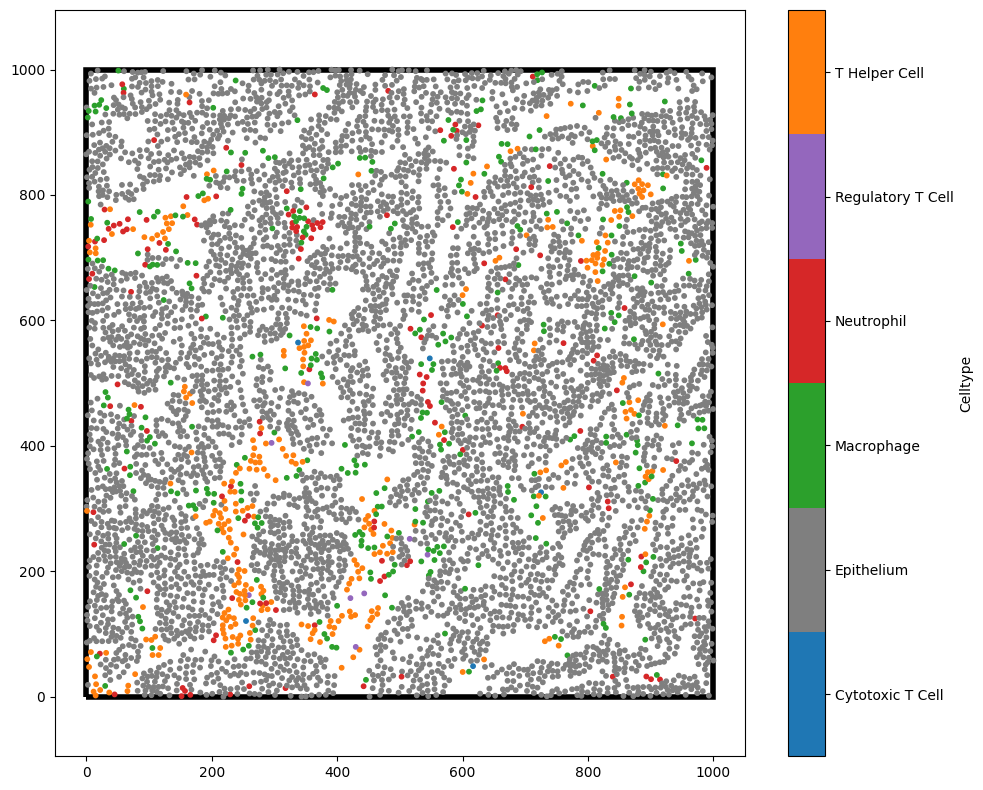

In [1]:
import muspan as ms
import matplotlib.pyplot as plt
import numpy as np  

# load in mouse carcinoma datasets stored within the MuSpAn package 
mouse_domain=ms.datasets.load_example_domain('Mouse-Colon-Carcinoma')

# Plot the data - making sure to show the boundary
ms.visualise.visualise(mouse_domain,color_by='Celltype',marker_size=10,show_boundary=True)

We'll first consider the Ripley's K function in it's most basic form, analysing the spatial distribution of a single population. 

To demonstrate this, take the T-helper cells (orange points) in the above domain. In it's most simple form, for each T-helper cell, Ripley's K is placing a disc of radius $r$ about these cells and computing the density of T-helper cells (orange points) that fall within this disc. Each of these observations is then normalised to the expected number of T-helper cells we would see within each disc if these cells were randomly distributed across the domain (Poisson point process). Once each disc has been normalised, the average of these normalised counts is taken for all cells. The process is repeated for increasing values of $r$.

Critically, complete randomness in Ripley's K is estimated as values near $\pi r^{2}$. Values of Ripley's K above $\pi r^{2}$ represent co-localisation up to distance $r$, whereas values below $\pi r^{2}$ indicate exclusion of points up to the distance $r$.

For completeness, the empirical Ripley's K function, $K(r)$, is defined mathematically by
$$
\begin{equation}
K(r) = \frac{A}{N(N-1)}\sum_{i=1}^{N}\sum_{j=1,j \neq i}^{N} \frac{\mathbf{1}(d_{ij}\leq r)}{A_{i} (r)},
\end{equation}
$$

where $A$ is the total area of the domain and $A_{i}(r)$ is the area of the disc about point $i$. $N$ is the total number of points in the population and $d_{ij}$ is the distance between the points $i$ and $j$. The function $\mathbf{1}(\cdot)$ is an indicator function that identifies if a point is within the disc, such that

$$
\begin{equation}
\mathbf{1}(d_{ij}\leq r) = \begin{cases}
1 \quad \text{if} \, d_{ij}\leq r, \\
0 \quad \text{else}.
\end{cases}
\end{equation}
$$

To reiterate, we say that the points exhibit:

- Co-localisation up to distance $r$ if $K(r) > \pi r ^{2}$, 
- Exclusion up to distance $r$ if $K(r) < \pi r ^{2}$
- Complete randomness up to distance $r$  if if $K(r) \approx \pi r ^{2}$
 
We've added this more formal description of Ripley's K to link our intuition of the process to what you might see in the literature. 

There are some subtleties to be aware of with correcting for the boundaries when computing the densities about points in the domain, but luckily MuSpAn accounts for these automatically by adaptively adjusting the growing discs to stay within the specified boundary of the domain. Below, we show the computation process of Ripley's K with increasing radii about the T-Helper cells.


Text(0.5, 1.0, 'r = 120µm')

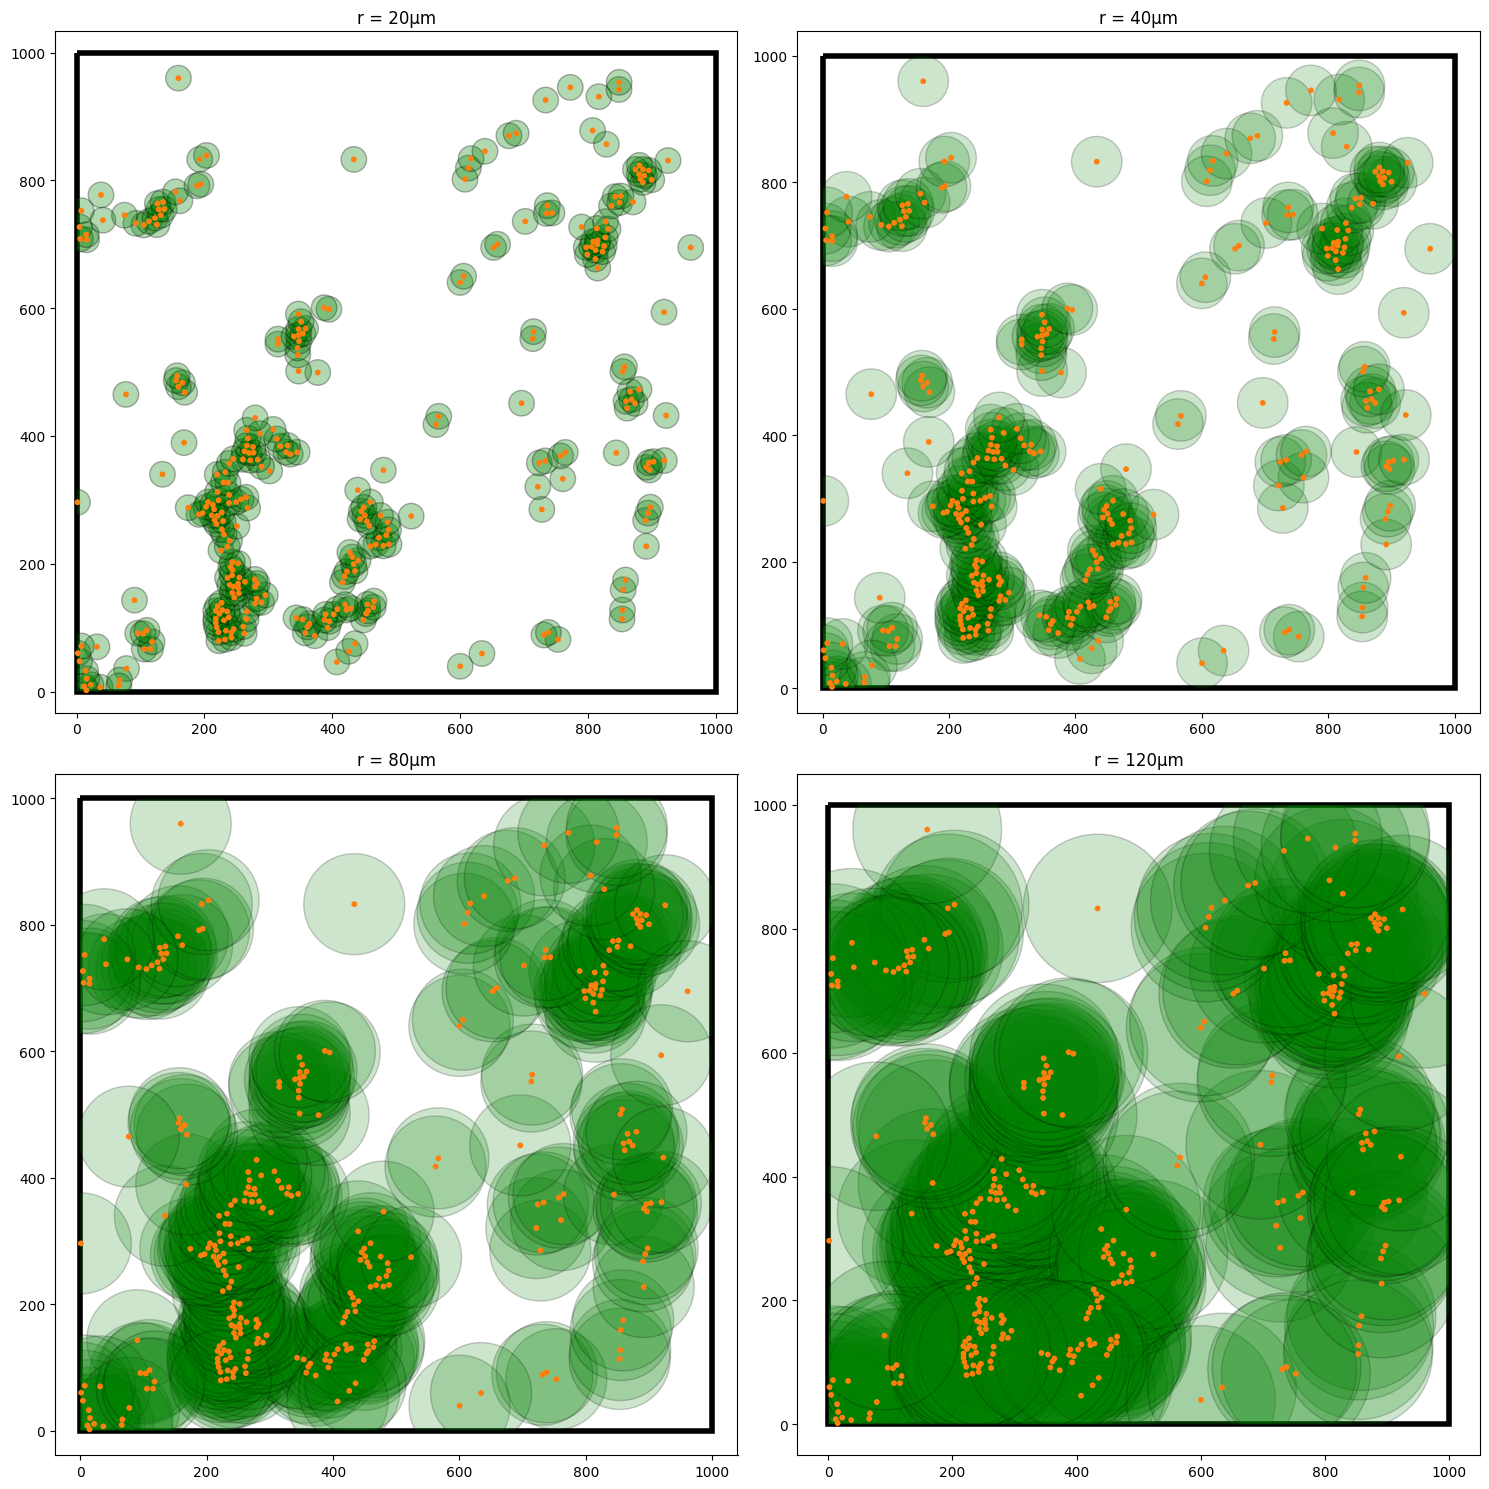

In [2]:
### This is code is purely for visualisation of the Ripley's K computational method ###

# Define helper functions to draw some shapes
def make_circle(centre, radius, nVerts=50):
    pts = []
    for v in range(nVerts):
        theta = -v * 2 * np.pi / nVerts
        pts.append([radius * np.cos(theta), radius * np.sin(theta)])
    pts = pts + np.asarray(centre)
    return np.asarray(pts)

# Define the boundary and the circles for T Helper Cells
boundary=np.array([[0,0],[1000,0],[1000,1000],[0,1000]])
centroids_t,_=ms.query.get_centroids(mouse_domain, population=('Celltype','T Helper Cell'))

circles_20 = [make_circle(centroid, 20) for centroid in centroids_t]
circles_40 = [make_circle(centroid, 40) for centroid in centroids_t]
circles_80 = [make_circle(centroid, 80) for centroid in centroids_t]
circles_120 = [make_circle(centroid, 120) for centroid in centroids_t]

# add the circles to the domain
mouse_domain.add_shapes(circles_20, collection_name='T Helper Cell radius 20')
mouse_domain.add_shapes(circles_40, collection_name='T Helper Cell radius 40')
mouse_domain.add_shapes(circles_80, collection_name='T Helper Cell radius 80')
mouse_domain.add_shapes(circles_120, collection_name='T Helper Cell radius 120')
crop_ID_local=mouse_domain.add_shapes([boundary], collection_name='Boundary shape',return_IDs=True)

# Crop the cirles to the domain boundary
mouse_domain = ms.helpers.crop_domain(mouse_domain, shape=crop_ID_local)[crop_ID_local[0]]

# Visualise the domain with the circles and T Helper Cells at different radii
fig,ax=plt.subplots(2,2,figsize=(15,15))
ms.visualise.visualise(mouse_domain,objects_to_plot=('collection','T Helper Cell radius 20'), marker_size=5, ax=ax[0,0],shape_kwargs=dict(facecolor='green', alpha=0.3),add_cbar=False)
ms.visualise.visualise(mouse_domain, color_by='Celltype',objects_to_plot=('Celltype','T Helper Cell'), marker_size=10, ax=ax[0,0],add_cbar=False,show_boundary=True)
ax[0,0].set_title('r = 20µm')

ms.visualise.visualise(mouse_domain,objects_to_plot=('collection','T Helper Cell radius 40'), marker_size=5, ax=ax[0,1],shape_kwargs=dict(facecolor='green', alpha=0.2),add_cbar=False)
ms.visualise.visualise(mouse_domain, color_by='Celltype',objects_to_plot=('Celltype','T Helper Cell'), marker_size=10, ax=ax[0,1],add_cbar=False,show_boundary=True)
ax[0,1].set_title('r = 40µm')

ms.visualise.visualise(mouse_domain,objects_to_plot=('collection','T Helper Cell radius 80'), marker_size=5, ax=ax[1,0],shape_kwargs=dict(facecolor='green', alpha=0.2),add_cbar=False)
ms.visualise.visualise(mouse_domain, color_by='Celltype',objects_to_plot=('Celltype','T Helper Cell'), marker_size=10, ax=ax[1,0],add_cbar=False,show_boundary=True)
ax[1,0].set_title('r = 80µm')

ms.visualise.visualise(mouse_domain,objects_to_plot=('collection','T Helper Cell radius 120'), marker_size=5, ax=ax[1,1],shape_kwargs=dict(facecolor='green', alpha=0.2),add_cbar=False)
ms.visualise.visualise(mouse_domain, color_by='Celltype',objects_to_plot=('Celltype','T Helper Cell'), marker_size=10, ax=ax[1,1],add_cbar=False,show_boundary=True)
ax[1,1].set_title('r = 120µm')

Now we have a good idea of what Ripley's K is measuring, we can now look to compute this using MuSpAn.

The Ripley's K function can be computed using the [cross_k_function](../../generated/muspan.spatial_statistics.cross_k_function.html) in the spatial_statistics submodule of the MuSpan package. In fact, this implementation is a more generalised version of Ripley's K where we can allow for two populations. We'll see this soon but for now we just want to compute the standard Ripley's K on our T-Helper cells in our domain.

To compute Ripley's K function on a single population, simply set both `population_A` and `population_B` as the same set of objects. We'll demonstrate this below upto a radius of 200µm and visualise the output with the handy `visualise_output` parameter.

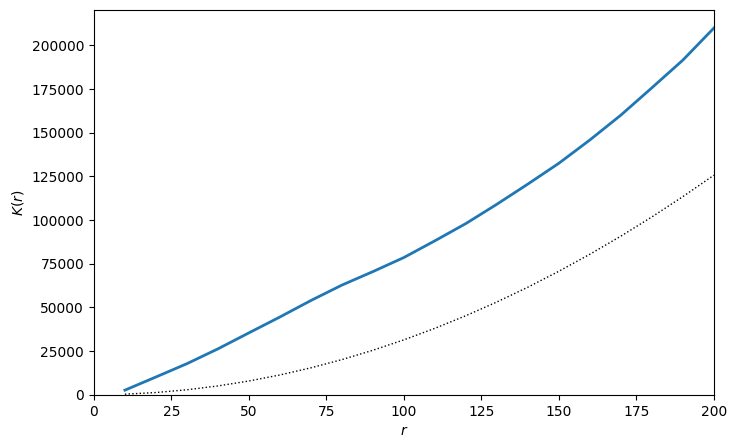

In [3]:
radius,rip_K=ms.spatial_statistics.cross_k_function(mouse_domain, 
                                                    population_A=('Celltype', 'T Helper Cell'), 
                                                    population_B=('Celltype', 'T Helper Cell'),
                                                    max_R=200,
                                                    visualise_output=True)


Now we have our K-curve, we can see that the estimated Ripley's K values on the T Helper Cell is greater than $\pi r^{2}$ (the dashed line) for all values of $r$. This means we are observing that T Helper Cells are co-localised for all distances upto 200µm, i.e., we are seeing more T Helper Cells in each disc than we would expect to see if the T Helpers were randomly distributed throughout the domain. 

This makes senses as T helpers are usually refined to the stroma regions of the tissues and therefore if present are more likely to be found close to eachother. This is were choice of boundary for computation is important. For more information on this, we recommend see our tutorial on [selecting boundaries for spatial statistics](Spatial%20stats%20-%202%20-%20boundary%20corrections.html).

 **Computing Ripley's K between populations: The Cross-K function**

We might also in how the spatial distribution of one population of cells is related to another population. For example, where are the T-Helper cells relative to Epithelium. Similar to the cross-PCF, the Cross-K extends the standard Ripley's K function allow for these cross population analyses.

For the cross-K function, we grow discs of increasing radii about objects in population A and compute the density of population B. As before, we compare these density observations of population B to the expected density of objects B for a given null distribution. As before, we consider this as complete spatial randomness.

The cross-K function has the same interpretation as Ripley's K with values above $\pi r^{2}$ represent co-localisation of population A with population B up to distance $r$, whereas values below $\pi r^{2}$ indicate exclusion up to the distance $r$.

Just to consolidate our intuition, we'll once again plot our growing discs about the T-Helper cells, but this time, we'll also show the Epithelial cells too as we'll now compute the cross-K from T-helper to Epithelium.

Text(0.5, 1.0, 'r = 120µm')

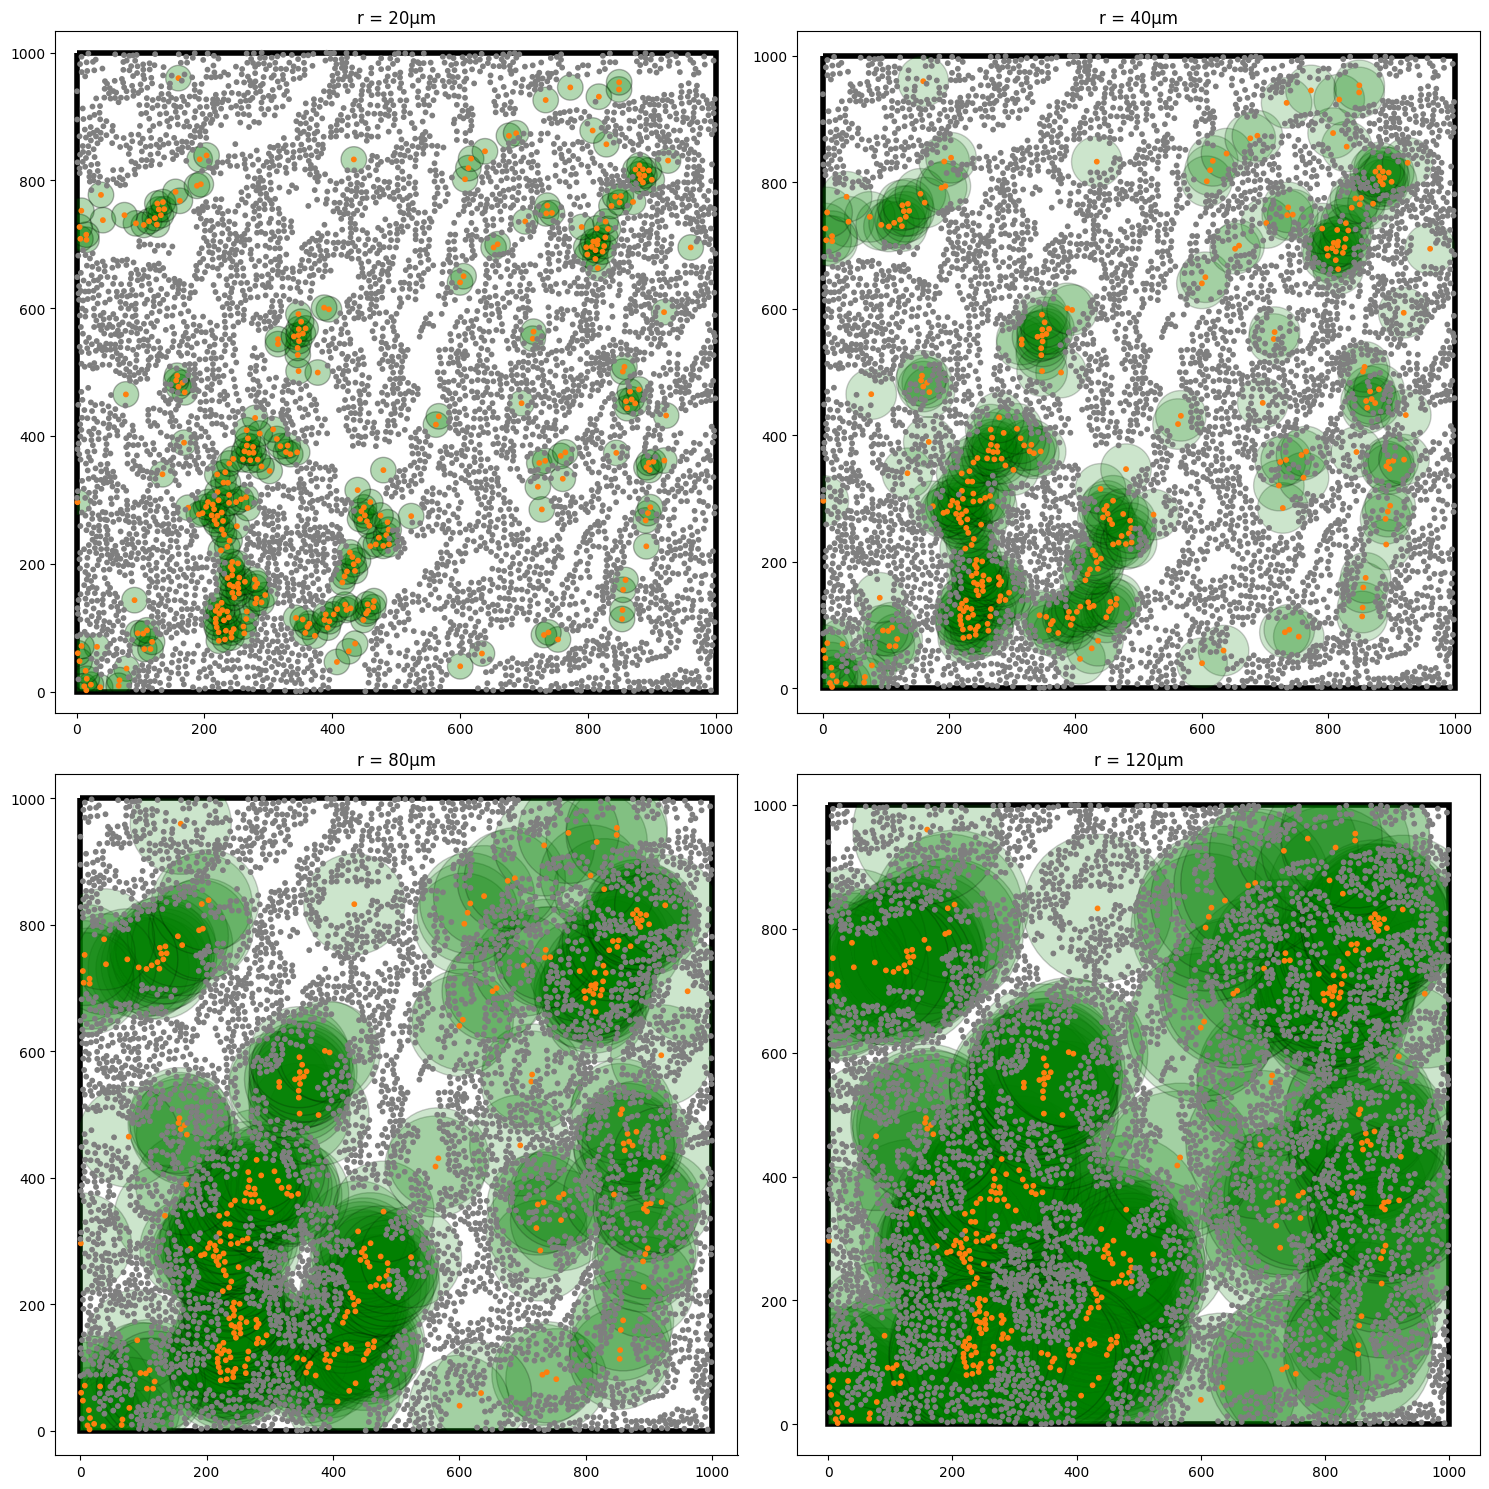

In [4]:
fig,ax=plt.subplots(2,2,figsize=(15,15))
ms.visualise.visualise(mouse_domain,objects_to_plot=('collection','T Helper Cell radius 20'), marker_size=5, ax=ax[0,0],shape_kwargs=dict(facecolor='green', alpha=0.3),show_boundary=True,add_cbar=False)
ms.visualise.visualise(mouse_domain, color_by='Celltype',objects_to_plot=('Celltype','T Helper Cell'), marker_size=10, ax=ax[0,0],add_cbar=False)
ms.visualise.visualise(mouse_domain, color_by='Celltype',objects_to_plot=('Celltype','Epithelium'), marker_size=10, ax=ax[0,0],add_cbar=False)

ax[0,0].set_title('r = 20µm')

ms.visualise.visualise(mouse_domain,objects_to_plot=('collection','T Helper Cell radius 40'), marker_size=5, ax=ax[0,1],shape_kwargs=dict(facecolor='green', alpha=0.2),show_boundary=True,add_cbar=False)
ms.visualise.visualise(mouse_domain, color_by='Celltype',objects_to_plot=('Celltype','T Helper Cell'), marker_size=10, ax=ax[0,1],add_cbar=False)
ms.visualise.visualise(mouse_domain, color_by='Celltype',objects_to_plot=('Celltype','Epithelium'), marker_size=10, ax=ax[0,1],add_cbar=False)
ax[0,1].set_title('r = 40µm')

ms.visualise.visualise(mouse_domain,objects_to_plot=('collection','T Helper Cell radius 80'), marker_size=5, ax=ax[1,0],shape_kwargs=dict(facecolor='green', alpha=0.2),show_boundary=True,add_cbar=False)
ms.visualise.visualise(mouse_domain, color_by='Celltype',objects_to_plot=('Celltype','T Helper Cell'), marker_size=10, ax=ax[1,0],add_cbar=False)
ms.visualise.visualise(mouse_domain, color_by='Celltype',objects_to_plot=('Celltype','Epithelium'), marker_size=10, ax=ax[1,0],add_cbar=False)
ax[1,0].set_title('r = 80µm')

ms.visualise.visualise(mouse_domain,objects_to_plot=('collection','T Helper Cell radius 120'), marker_size=5, ax=ax[1,1],shape_kwargs=dict(facecolor='green', alpha=0.2),show_boundary=True,add_cbar=False)
ms.visualise.visualise(mouse_domain, color_by='Celltype',objects_to_plot=('Celltype','T Helper Cell'), marker_size=10, ax=ax[1,1],add_cbar=False)
ms.visualise.visualise(mouse_domain, color_by='Celltype',objects_to_plot=('Celltype','Epithelium'), marker_size=10, ax=ax[1,1],add_cbar=False)
ax[1,1].set_title('r = 120µm')

We can see that actually there are many grey points missing from these green disc as the radii grow. This my indicate exlusion of our T-helpers and Epithelial cells. Let's now compute the cross-K function between these populations as we did before, but now modifying our second population to being the Epithelial cells.

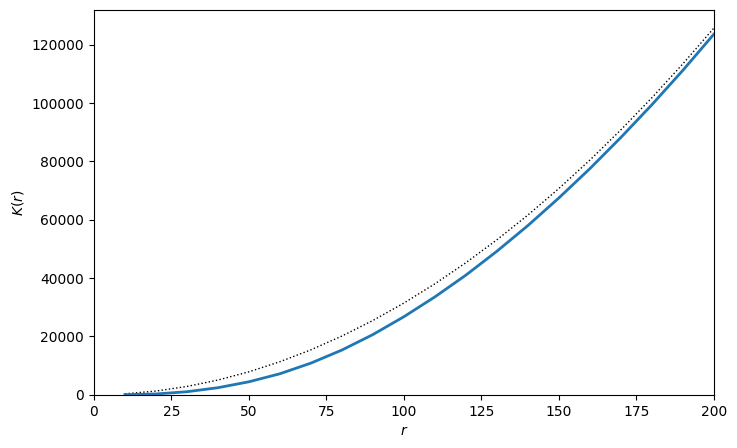

In [5]:
radius,rip_K_T_to_E=ms.spatial_statistics.cross_k_function(mouse_domain, 
                                                           population_A=('Celltype','T Helper Cell'), 
                                                           population_B=('Celltype','Epithelium'),
                                                           max_R=200,
                                                           visualise_output=True)

As we might have expected, our K-curve is now below the null-line of $\pi r^{2}$ indicating exlusion between these populations for all radii up to a distance 200µm. Once again, this might be a result of these cells being restricted to separate compartments of the tissue and thus a consideration of the correct boundary to use is needed.

We can compute the cross-K for all Celltype pairs in our domain, noting once again our same population computations (i.e., macrophage-macrophage) is the standard Ripley's K function.

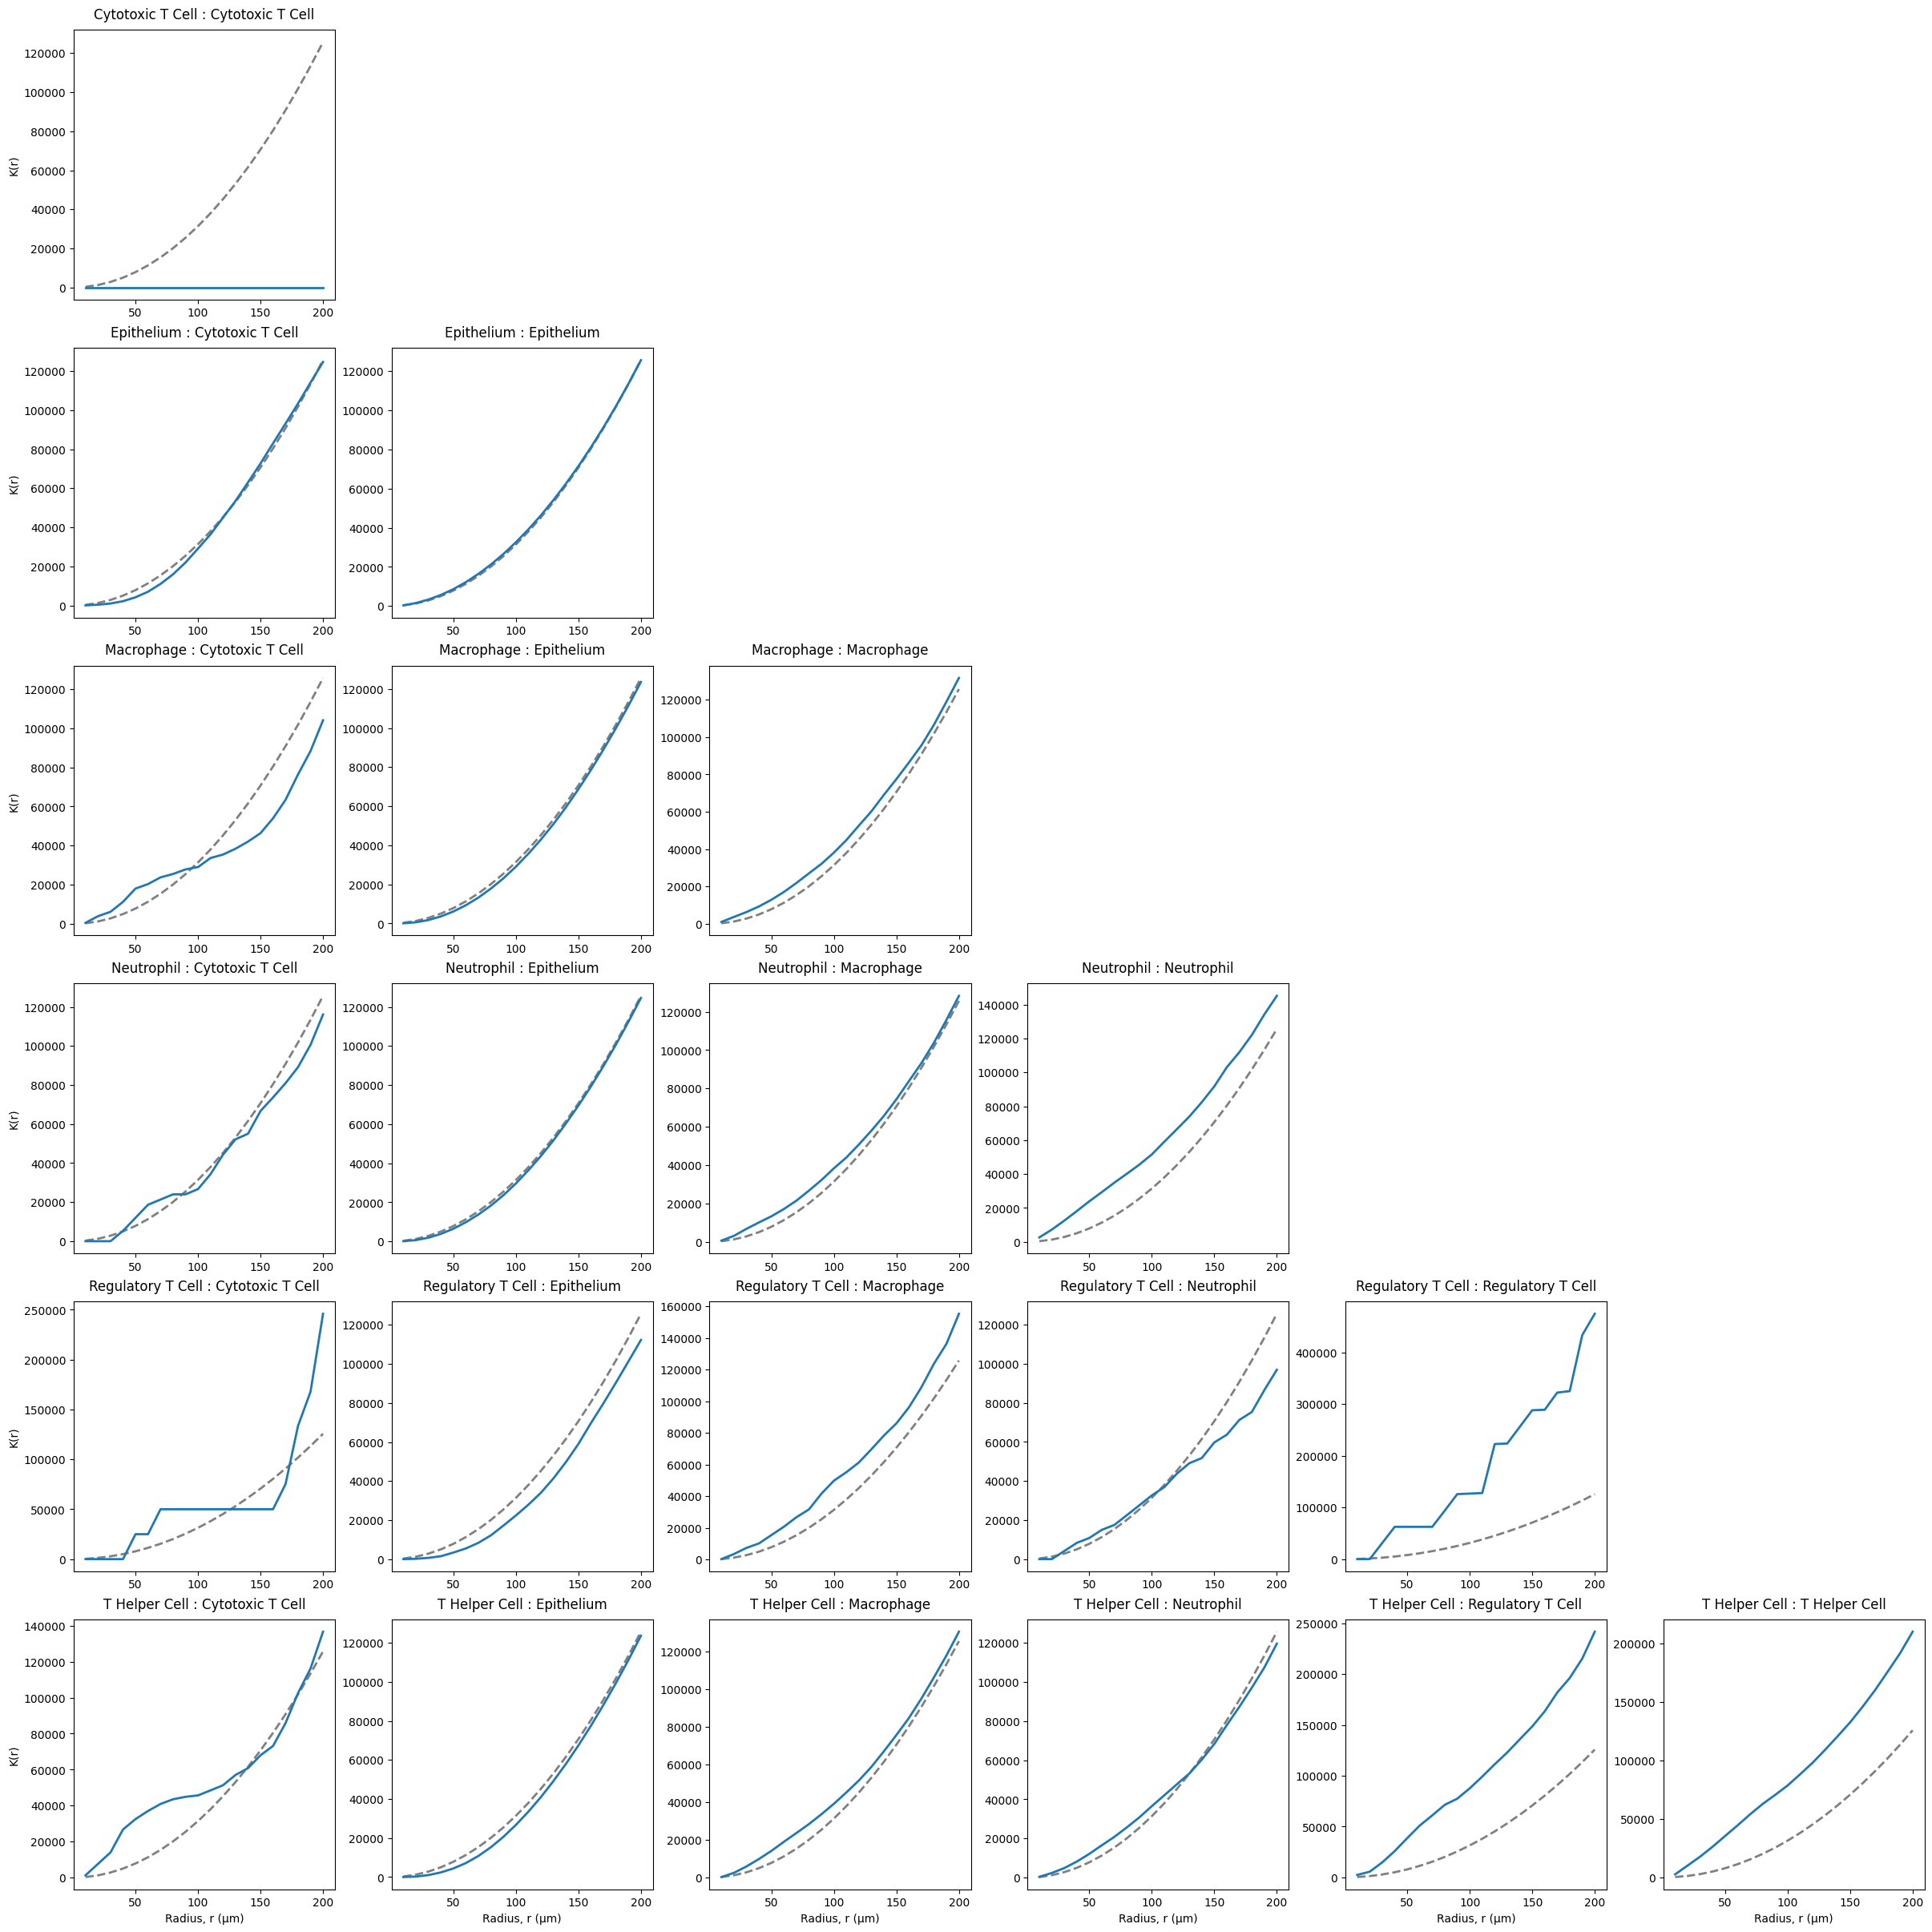

In [6]:
Celltypes=['Cytotoxic T Cell', 'Epithelium', 'Macrophage', 'Neutrophil','Regulatory T Cell', 'T Helper Cell']

# Create a grid of subplots for each cell type combination
fig, ax = plt.subplots(len(Celltypes), len(Celltypes), figsize=(4 * len(Celltypes), 4 * len(Celltypes)), constrained_layout=True)

# Loop through each combination of cell types and calculate the cross K-function 
for i,celltype_A in enumerate(Celltypes):
    for j, celltype_B in enumerate(Celltypes):
        if j<=i:
            radius,rip_K=ms.spatial_statistics.cross_k_function(mouse_domain, 
                                                                population_A=('Celltype', celltype_A), 
                                                                population_B=('Celltype', celltype_B),
                                                                max_R=200,
                                                                visualise_output=False)
            
            ax[i,j].plot(radius,np.pi*radius**2, linestyle='--', color='grey',linewidth=2)
            ax[i,j].plot(radius,rip_K,linewidth=2)
            ax[i,j].set_title(f'{celltype_A} : {celltype_B}', pad=10, loc='center')
            
            if i==len(Celltypes)-1:
                ax[i,j].set_xlabel('Radius, r (µm)')
            if j==0:
                ax[i,j].set_ylabel('K(r)')
        else:
            ax[i,j].axis('off')




**Links with the Pair Correlation Funciton**

As we've seen, Ripley’s- K function, $K(r)$, and the pair correlation function (PCF), $g(r)$, are both tools used in spatial statistics to describe how points (e.g. cells, individuals, or events) are distributed in space.

But infact these two are closely linked. As in our tutorial on the PCF, the PCF focuses on the *relative likelihood* of finding a pair of points separated by a distance $r$, compared to what would be expected under CSR. The PCF can be defined such that  

$$
\begin{equation}
g(r) = \frac{1}{2\pi r} \frac{dK(r)}{dr},
\end{equation}
$$

which means $g(r)$ is the derivative of $K(r)$ scaled by the circumference of a circle of radius $r$.

In intuitive terms:  
- $K(r)$ is **cumulative**: it tells you how many neighbors lie *within* radius $r$.  
- $g(r)$ is **local**: it tells you how likely it is to find neighbors *at* exactly distance $r$.

Dependent on your question and data, chosing the right statistic, Ripley's K or PCF, can greatly improve interpretability of the measurement. For more information on the links between Ripley's K and the PCF, check out [this reference (pp 218-223,232-244)](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470725160).